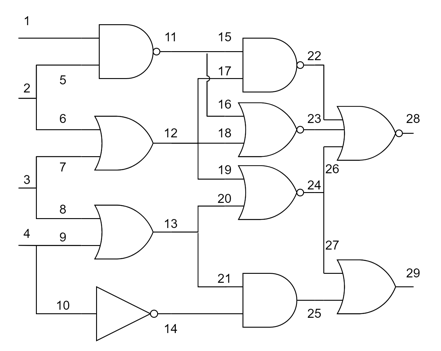

In [1]:
from PIL import Image

img = Image.open('rangkaian.png')
w, h = img.size # width height
scl = 0.3
img = img.resize (( int(w*scl), int(h*scl) ))
img

In [12]:
import copy
import numpy as np

"""
jenis gate
0: buffer
1: not
2: and
3: nand
4: or
5: nor
"""

# inisialisasi rangkaian
# urutan penulisan: [jenis gate, output, input1, input2 (jika ada), input3 (jika ada)]
circuit = [ # circuit yang digambarkan seperti VHDL
    [0, 5, 2],
    [0, 6, 2],
    [0, 7, 3],
    [0, 8, 3],
    [0, 9, 4],
    [0, 10, 4],
    [3, 11, 1, 5], #
    [4, 12, 6, 7], #
    [4, 13, 8, 9], #
    [1, 14, 10],
    [0, 15, 11],
    [0, 16, 11],
    [0, 17, 12],
    [0, 18, 12],
    [0, 19, 12],
    [0, 20, 13],
    [0, 21, 13],
    [3, 22, 15, 17], #
    [5, 23, 16, 18], #
    [5, 24, 19, 20], #
    [2, 25, 21, 14], #
    [0, 26, 24],
    [0, 27, 24],
    [5, 28, 22, 23, 26], #
    [4, 29, 27, 25], #
]
circuit_out = [] # node output dari circuit
for i in range (len(circuit)):
    circuit_out.append (circuit[i][1])

# node input dan output
n_input = 4
n_testVector = pow(2, n_input)
PI = [1, 2, 3, 4] # node primary input
PO = [28, 29] # node primary output


# fungsi-fungsi
def intTo4BitBinary (num):
    output = [0 for i in range (4)]
    temp = num
    for i in range (4):
        output[3-i] = int(temp % 2)
        temp = (temp-output[3-i]) / 2
    return (output)

def calcOutput (node_out, input): # input = [arr node input, arr nilai input]
    if (node_out in input[0]): # base
        index = input[0].index(node_out)
        return (input[1][index])
    else: # rekursif
        index = circuit_out.index(node_out)
        if (circuit[index][0] == 0): # gerbang buffer
            output = calcOutput (circuit[index][2], input)
        elif (circuit[index][0] == 1): # gerbang not
            output = not (calcOutput (circuit[index][2], input))
        elif (circuit[index][0] == 2): # gerbang and
            arr_in = [calcOutput(ele, input) for ele in circuit[index][2:]]
            output = not (0 in arr_in)
        elif (circuit[index][0] == 3): # gerbang nand
            arr_in = [calcOutput(ele, input) for ele in circuit[index][2:]]
            output = 0 in arr_in
        elif (circuit[index][0] == 4): # gerbang or
            arr_in = [calcOutput(ele, input) for ele in circuit[index][2:]]
            output = 1 in arr_in
        elif (circuit[index][0] == 5): # gerbang nor
            arr_in = [calcOutput(ele, input) for ele in circuit[index][2:]]
            output = not (1 in arr_in)
        # print (node_out, output)
        return (output)

def updateInput (arrInput, node, value):
    if (node in arrInput[0]): # jika node sudah ada di array
        index = arrInput[0].index(node)
        arrInput[1][index] = value
    else: # jika node belum ada di array
        arrInput[0].append(node)
        arrInput[1].append(value)

def detectFault (testVector, cp):
    arr_fault = [0 for i in range (len(cp) * 2)]
    input = [copy.deepcopy(PI), testVector]
    freeFaultOut = [calcOutput(ele, input) for ele in PO]
    # cek fault
    for i in range (len(cp)):
        input2 = copy.deepcopy(input)
        cpFaultOut = not(calcOutput(cp[i], input2)) # output di cp ketika terjadi fault
        updateInput (input2, cp[i], cpFaultOut) # update array input
        faultOut = [calcOutput(ele, input2) for ele in PO] # output di PO ketika terjadi fault
        if (freeFaultOut != faultOut): # jika fault terdeteksi (freeFaultOut dan faultOut berbeda)
            # update arr_fault
            if (cpFaultOut): # cp stuck at 1
                arr_fault[i+len(cp)] = 1
            else: # cp stuck at 0
                arr_fault[i] = 1
    return (arr_fault)

def detectAllFault (n_testVector, cp):
    tabel_fault = []
    for i in range (n_testVector):
        testVector = intTo4BitBinary (i)
        tabel_fault.append (detectFault (testVector, cp))
    tabel_fault = np.array(tabel_fault) # ubah ke array numpy

    merge_fault = 0 # total semua fault yang bisa terdeteksi jika digunakan semua test vector
    for i in range (len(tabel_fault)):
        merge_fault |= tabel_fault[i]
    
    return (tabel_fault, merge_fault)

def testVectorReduction (tabel_fault, merge_fault): # penyederhanaan test vector
    set_fault = []
    for i in range (len(tabel_fault)): # ubah tabel_fault menjadi set_fault yang hanya berisi index dari tabel_fault yang bernilai 1
        temp = []
        for j in range (len(tabel_fault[0])):
            if (tabel_fault[i][j]):
                temp.append(j)
        set_fault.append(temp)
    # print set_fault
    # for i in range (len(set_fault)):
    #     print(i, set_fault[i])#, len (set_fault[i]))

    X = [] # index dari fault yang belum tercover
    for i in range (len(merge_fault)):
        if (merge_fault[i]):
            X.append(i)
    X = np.array(X)
    # print (X)
    
    # algoritma greedy untuk set cover problem
    C = [] # array output yang berisi index dari test vector
    while ((len(X) != 0)): # X masih ada isi
        temp_X = copy.deepcopy(X) # copy X
        temp_C = 0
        for i in range (len(set_fault)):
            if (i not in C): # jika i belum ada di C
                temp = copy.deepcopy(X)
                temp = np.setdiff1d (temp, set_fault[i], assume_unique=True) # set difference
                if (len(temp) < len(temp_X)):
                    temp_X = temp
                    temp_C = i
        X = copy.deepcopy(temp_X)
        C.append (temp_C)
    
    return (C)


# testing pasangan input output
input = [copy.deepcopy(PI), [0, 0, 0, 0]]

for i in range (n_testVector):
    input[1] = intTo4BitBinary (i)
    free_fault_out = [calcOutput(ele, input) for ele in PO]
    print (input[1], end="")
    print (free_fault_out)

[0, 0, 0, 0][False, True]
[0, 0, 0, 1][False, False]
[0, 0, 1, 0][True, True]
[0, 0, 1, 1][True, False]
[0, 1, 0, 0][True, False]
[0, 1, 0, 1][True, False]
[0, 1, 1, 0][True, True]
[0, 1, 1, 1][True, False]
[1, 0, 0, 0][False, True]
[1, 0, 0, 1][False, False]
[1, 0, 1, 0][True, True]
[1, 0, 1, 1][True, False]
[1, 1, 0, 0][False, False]
[1, 1, 0, 1][False, False]
[1, 1, 1, 0][False, True]
[1, 1, 1, 1][False, False]


In [13]:
cp = copy.deepcopy(PI) # node-node penting yang perlu dicek faultnya sesuai teorema checkpoints
cp.extend (circuit_out) # tidak pakai teorema checkpoints (semua node dicek faultnya)
# for i in range(len(circuit)): # pakai teorema checkpoints
#     if (circuit[i][0] == 0):
#         cp.append(circuit[i][1])
# print (cp)

tabel_fault = [] # tabel yang berisi semua fault yang terdeteksi sesuai dengan masing-masing test vector
# [cp[0]sa0, ..., cp[n]sa0, cp[0]sa1, ...cp[n]sa1]
merge_fault = 0 # total semua fault yang bisa terdeteksi jika digunakan semua test vector
tabel_fault, merge_fault = detectAllFault (n_testVector, cp) # detect semua fault dengan metode exhaustive (hasilnya dimasukkan ke tabel_fault)


# print
# for i in range (len(tabel_fault)):
#     print (i, list(tabel_fault[i]))
# print (list(merge_fault))


# hitung fault coverage
sum = len([ele for ele in merge_fault if ele == 1]) # hitung merge_fault yang bernilai 1
print ("Fault Coverage: %.2f%%\n" % (sum/len(merge_fault)*100))


# reduksi test vector
testVectorIndex = testVectorReduction (tabel_fault, merge_fault)
# print ("Test Vector Index:")
# print (testVectorIndex)
# print ()



# convert test vector
print ("Test Vector:")
testVector = [0 for i in range (len(testVectorIndex))]
for i in range (len (testVectorIndex)):
    testVector[i] = intTo4BitBinary(testVectorIndex[i])
    print (testVector[i])
print ()


# verifikasi hasil
# detect fault
tabel_fault_verifikasi = []
for i in range (len(testVector)):
    tabel_fault_verifikasi.append (detectFault (testVector[i], cp))
tabel_fault_verifikasi = np.array(tabel_fault_verifikasi)
# merge fault
merge_fault_verifikasi = 0
for i in range (len(tabel_fault_verifikasi)):
    merge_fault_verifikasi |= tabel_fault_verifikasi[i]
print (merge_fault_verifikasi)
# ubah merge_fault_verifikasi ke dalam bentuk set
set_merge_fault_verifikasi = [] # index dari fault yang belum tercover
for i in range (len(merge_fault_verifikasi)):
    if (merge_fault_verifikasi[i]):
        set_merge_fault_verifikasi.append(i)
set_merge_fault_verifikasi = np.array(set_merge_fault_verifikasi)
print (set_merge_fault_verifikasi)
print (np.array_equiv(merge_fault, merge_fault_verifikasi))

Fault Coverage: 89.66%

Test Vector:
[0, 1, 0, 0]
[1, 1, 1, 0]
[0, 0, 0, 1]
[0, 0, 0, 0]
[1, 0, 1, 0]

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 18 19 20 21 23 24 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 47 48 49 50 51 52 53
 54 55 56 57]
True


In [283]:
# Script untuk mencari rangkaian yang memiliki semua gate lengkap (AND, NAND, OR, NOR)
def randGate():
    out = []
    temp = [6, 7, 8, 17, 18, 19, 20, 23, 24]
    # randomize gate
    for ele in temp:
        circuit[ele][0] = np.random.randint(2, 6)
        out.append (circuit[ele][0])
    return (out)
randGate()

for i in range (100):
    out = randGate()
    temp = [0, 0, 0, 0]
    for i in range (16):
        input[1] = intTo4BitBinary (i)
        free_fault_out = [calcOutput(28, input), calcOutput(29, input)]
        # print (input[1], end="")
        # print (free_fault_out)
        if (free_fault_out[0]==0) & (free_fault_out[1]==0):
            temp[0] += 1
        elif (free_fault_out[0]==0) & (free_fault_out[1]==1):
            temp[1] += 1
        elif (free_fault_out[0]==1) & (free_fault_out[1]==0):
            temp[2] += 1
        elif (free_fault_out[0]==1) & (free_fault_out[1]==1):
            temp[3] += 1
    # print (temp)
    if (0 not in temp):
        print (out, temp)
        break

# [5, 3, 3, 4, 2, 2, 2, 4, 5] [2, 2, 10, 2]
# [3, 3, 4, 2, 2, 4, 2, 2, 2] [4, 2, 8, 2]
# [2, 4, 5, 3, 3, 3, 3, 2, 2] [2, 3, 2, 9]

[3, 4, 4, 3, 5, 5, 2, 5, 4] [5, 3, 5, 3]
